In [2]:
import logging
import os
import pandas as pd
import json

from pathlib import Path

%load_ext autoreload
%autoreload 2

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "CRITICAL"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.FATAL))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.DEBUG)

%aimport setup

from setup import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Track Layout
Calculate the layout of the dutch railway system


In [3]:
layout_file =   "../data/prorail/parsed/netherlands-schiphol.json"
layout = Layout(layout_file)

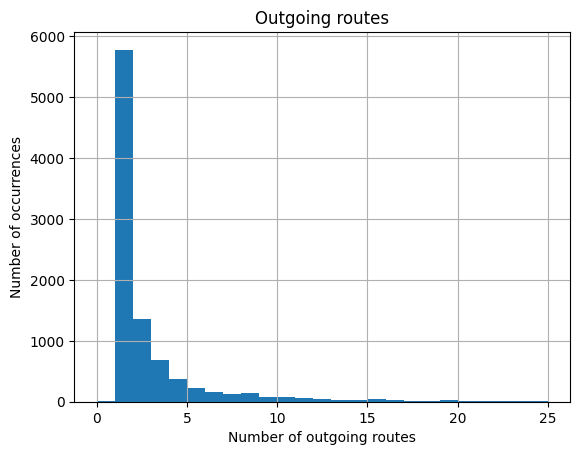

In [4]:
edges_df = pd.DataFrame({"Outgoing routes": [len(n.outgoing) for n in layout.g_block.nodes.values() if len(n.outgoing) <= 25]})
hist = edges_df.hist(bins=25, )
plt.xlabel("Number of outgoing routes")
plt.ylabel("Number of occurrences")
plt.show()

# Experiment Runtime
Take a route of an agent with many stops, and run from start to every stop as an experiment

In [17]:
scenario_file = "../data/prorail/scenarios/TAD/2025-07-08_4.json"
try:
    base_path = Path(__file__).parent
    file_path = (base_path / scenario_file).resolve()
    data = json.load(open(file_path))
except:
    data = json.load(open(scenario_file))
types = {x["name"]: x for x in data["types"]}
agents = []
for trainNumber, entry in enumerate(data["trains"]):
    trainNumber += 1
    move = entry["movements"][0]
    velocity = types[entry["trainUnitTypes"][0]]["speed"] / 3.6

    block_path = layout.get_path_for_agent(move, trainNumber, velocity)

    agent = Agent(trainNumber, move["startLocation"], move["endLocation"], velocity, move["startTime"],
                  endTime=move["endTime"],
                  startTimeHuman=str(timedelta(seconds=move["startTime"])),
                  endTimeHuman=str(timedelta(seconds=move["endTime"])),
                  blockPath=block_path,
                  trainNumber=entry["trainNumber"],
                  trainUnitTypes=entry["trainUnitTypes"],
                  stops=move["stops"]
    )
    agents.append(agent)

agent_df = pd.DataFrame([agent.__dict__ for agent in agents])
agent_df['blockPathLength'] = agent_df['blockPath'].map(len)

print(f"total blocks in path: {agent_df['blockPathLength'].sum()}")
print(f"total edges in graph: {edges_df['Outgoing routes'].sum()}")

agent_df

total blocks in path: 4640
total edges in graph: 23191


,id,origin,destination,velocity,start_time,endTime,startTimeHuman,endTimeHuman,blockPath,trainNumber,trainUnitTypes,stops,blockPathLength
0,1,LEDN|9b,VS|2,38.888889,660.0,9360.0,0:11:00,2:36:00,"[r-Ledn|1096--r-Gvm_Ledn|805, r-Gvm_Ledn|805--...",2268,[VIRM],"[{'expected_arrival': 1200.0, 'location': 'LAA...",140
1,2,SHL|1,VL|3,38.888889,720.0,8640.0,0:12:00,2:24:00,"[r-Shl|1066--r-Shl|1034, r-Shl|1034--r-Asra_Sh...",3577,[VIRM],"[{'expected_arrival': 1080.0, 'location': 'ASD...",151
2,3,ASD|2a,GVC|10,38.888889,2760.0,5940.0,0:46:00,1:39:00,"[r-Asd|84--r-Asd|76, r-Asd|76--r-Asd|4, r-Asd|...",2185,[VIRM],"[{'expected_arrival': 3060.0, 'location': 'ASS...",54
3,4,SSH|2,ASS|9,38.888889,120.0,2040.0,0:02:00,0:34:00,"[r-Hfd_Ledn|1982--r-Hfd_Ledn|1980, r-Hfd_Ledn|...",4377,[SLT],"[{'expected_arrival': 600.0, 'location': 'NVP|...",28
4,5,ASD|2a,VS|1,38.888889,60.0,11160.0,0:01:00,3:06:00,"[r-Asd|84--r-Asd|76, r-Asd|76--r-Asd|4, r-Asd|...",2270,[VIRM],"[{'expected_arrival': 420.0, 'location': 'ASS|...",182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,RTD|7,GVC|1,38.888889,120.0,1800.0,0:02:00,0:30:00,"[r-Rtd|282--r-Rtd|178, r-Rtd|178--r-Rmoa_Rtd|1...",5170,[SNG],"[{'expected_arrival': 360.0, 'location': 'SDM|...",28
60,61,DDR|3a,GVC|1,38.888889,2280.0,5400.0,0:38:00,1:30:00,"[r-Ddr|1236--r-Ddr|1306, r-Ddr|1306--r-Zwd|131...",5174,[SNG],"[{'expected_arrival': 2460.0, 'location': 'ZWD...",47
61,62,UT|5,GVC|9,38.888889,1260.0,5100.0,0:21:00,1:25:00,"[r-Ut|2680--r-Ut|2638, r-Ut|2638--r-Ut_Mas|233...",3172,[VIRM],"[{'expected_arrival': 2220.0, 'location': 'ASB...",79
62,63,GVC|11,ASS|9,38.888889,1920.0,5640.0,0:32:00,1:34:00,"[r-Gvc|5078--r-Laa|84, r-Laa|84--r-Laa|542, r-...",4381,[SLT],"[{'expected_arrival': 2100.0, 'location': 'LAA...",48


## Scenario

In [18]:
series_3500o = agent_df.loc[(agent_df['trainNumber'].str.startswith("35", na=False)) & (agent_df['trainNumber'].astype(int) % 2 == 1)].sort_values("start_time")
# This train would be at 2700 at GV|6, we will be replanning its path till ASDZ|2
agent = series_3500o.loc[series_3500o['stops'].map(len).idxmax()]
agent

id                                                                10
origin                                                         DDR|2
destination                                                     VL|3
velocity                                                   38.888889
start_time                                                     300.0
endTime                                                      12240.0
startTimeHuman                                               0:05:00
endTimeHuman                                                 3:24:00
blockPath          [r-Ddr|1238--r-Ddr|1306, r-Ddr|1306--r-Zwd|131...
trainNumber                                                     3581
trainUnitTypes                                                [VIRM]
stops              [{'expected_arrival': 960.0, 'location': 'RTB|...
blockPathLength                                                  233
Name: 9, dtype: object

In [19]:
# Replan these agents, -1 is planning in a new agent
agent_id = agent['id']
scenario = Scenario(layout, scenario_file)

## Experiment
Define an experiment for every stop, and the original start and stop


In [27]:
stops_df = pd.DataFrame(agent["stops"])
r_start = stops_df.loc[stops_df["location"].str.contains("GV", na=False)]
r_stop  = stops_df.loc[stops_df["location"].str.contains("ASDZ", na=False)]

r_start, r_stop

(   expected_arrival location    time
 4            2400.0     GV|6  2520.0,
    expected_arrival location    time
 8            4680.0   ASDZ|2  4800.0)

In [29]:
i_start = r_start.index[0] + 1
i_stop  = r_stop.index[0]
stops = agent["stops"][i_start:i_stop]

move = {
    "startLocation": r_start["location"].iloc[0],
    "startTime": r_start["time"].iloc[0],
    "endLocation": r_stop["location"].iloc[0],
    "endTime": r_stop["expected_arrival"].iloc[0],
    "stops": stops,
}

block_path = layout.get_path_for_agent(move, agent["trainNumber"], agent["velocity"])

def filter_origin(n):
    return n.split("-")[1].split("|")[0]

allowed_nodes = {filter_origin(block_path[0].from_node.name)}
for e in block_path:
    allowed_nodes.add(filter_origin(e.to_node.name))
allowed_nodes

{'Asdzo',
 'Asra',
 'Asra_Shl',
 'Gv',
 'Gvm',
 'Gvm_Ledn',
 'Hfd',
 'Hfd_Ledn',
 'Hfd_Shl',
 'Laa',
 'Ledn',
 'Shl'}

In [21]:
# Setup experiment
experiment_settings = [
    {
        "start_time": r_start["time"].iloc[0],
        "origin": r_start["location"].iloc[0],
        "destination": r_stop["location"].iloc[0],
        "filter_agents": agent_id,
        "metadata": {
            "offset": 2,
        },
    },
    {
        "start_time": r_start["time"].iloc[0],
        "origin": r_start["location"].iloc[0],
        "destination": r_stop["location"].iloc[0],
        "max_buffer_time": 900,
        "filter_agents": agent_id,
        "metadata": {
            "color": "Green",
            "label": "Buffer time",
            "offset": 1,
        }
    }, {
        "start_time": r_start["time"].iloc[0],
        "origin": r_start["location"].iloc[0],
        "destination": r_stop["location"].iloc[0],
        "max_buffer_time": 900,
        "use_recovery_time": True,
        "filter_agents": agent_id,
        "metadata": {
            "color": "Blue",
            "label": "Recovery time",
        }
    }
]

experiments = setup_experiment(scenario, experiment_settings, default_direction=1)

### Blocking staircase diagram
Showing the route of the agent with the most stops, its quite long.


C:\Users\erick\Documents\uni\Thesis\delay-replannning\generation\safe_interval_graph.py:139: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(timedelta(seconds=ytick)) for ytick in ax.get_yticks()])


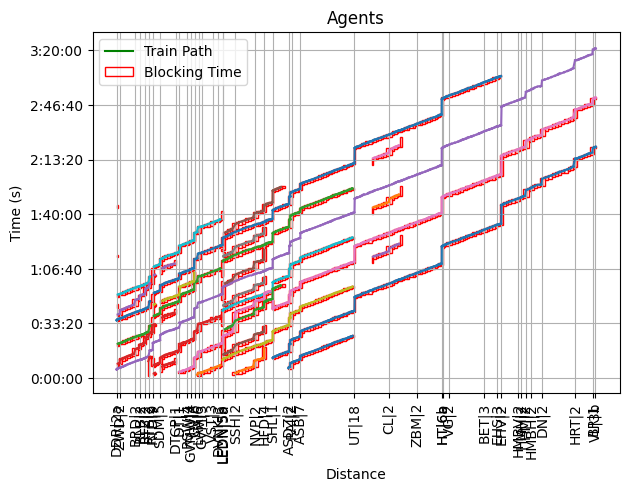

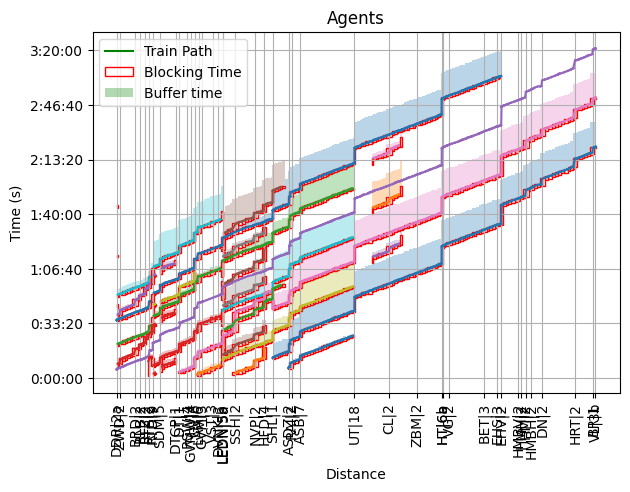

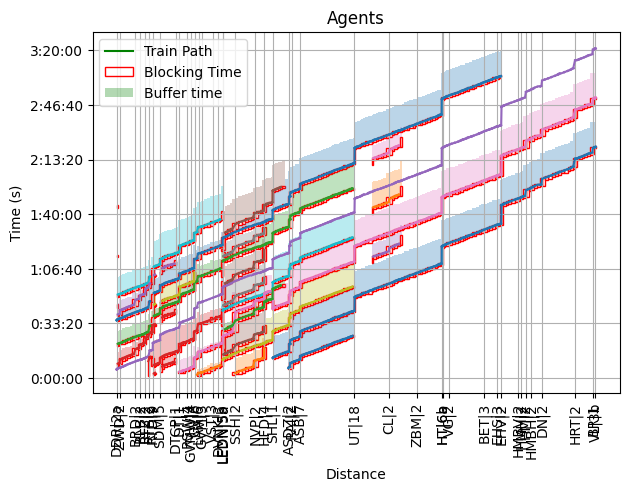

In [22]:
for exp in experiments:
    exp.s.plot(agent_id, exp.block_intervals, exp.buffer_times, exp.recovery_times, True)

In [41]:
timeout = 300
pybooklogger.setLevel(logging.DEBUG)
run_experiments(experiments, timeout, filter_tracks=allowed_nodes)

DEBUG:pybook.setup:Running: ../search/buildDir/atsipp.exe --start r-Gv|244 --goal r-Asdzo|764 --edgegraph output --search repeat --startTime 2520.0
DEBUG:pybook.setup:repeat output: ['<0,inf,inf,inf> <-inf,3186.34,5039.26,5039.26>', 'Nodes generated: 365 Nodes decreased: 122 Nodes expanded: 223', '<-inf,3186.34,5039.26,5039.26>, <3186.34,inf,inf,inf>, ', 'r-Gv|244 <1739.78,3186.34> ns:19 []', 'r-Gv|1822 <1740.18,3201.51> ns:1 []', 'r-Laa|1820 <1774.58,3468.75> ns:1 []', 'r-Laa|1818 <2017.27,3484.43> ns:1 []', 'r-Gvm|190 <2019.05,3521.03> ns:5 []', 'r-Gvm|170 <2033.97,3703.52> ns:5 []', 'r-Gvm|866 <2052.61,3705.5> ns:1 []', 'r-Gvm_Ledn|856 <2095.68,3720.42> ns:1 []', 'r-Gvm_Ledn|846 <2137.21,3742.61> ns:1 []', 'r-Gvm_Ledn|836 <2219.83,3785.68> ns:1 []', 'r-Gvm_Ledn|826 <2216.28,3827.21> ns:1 []', 'r-Gvm_Ledn|816 <2253.18,3906.28> ns:1 []', 'r-Gvm_Ledn|806 <2289.26,3906.28> ns:1 []', 'r-Ledn|1114 <2298.41,3943.18> ns:29 []', 'r-Ledn|1066 <0,25920> ns:1 []', 'r-Ledn|1030 <0,25920> ns:71 [

## Results


### ATF Plot

C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\setup.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[0].get_xticks()])
C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\setup.py:81: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_yticklabels([str(timedelta(seconds=ytick)) for ytick in axs[0].get_yticks()])
C:\Users\erick\Documents\uni\Thesis\delay-replannning\experiments\setup.py:82: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels([str(timedelta(seconds=xtick)) for xtick in axs[1].get_xticks()])


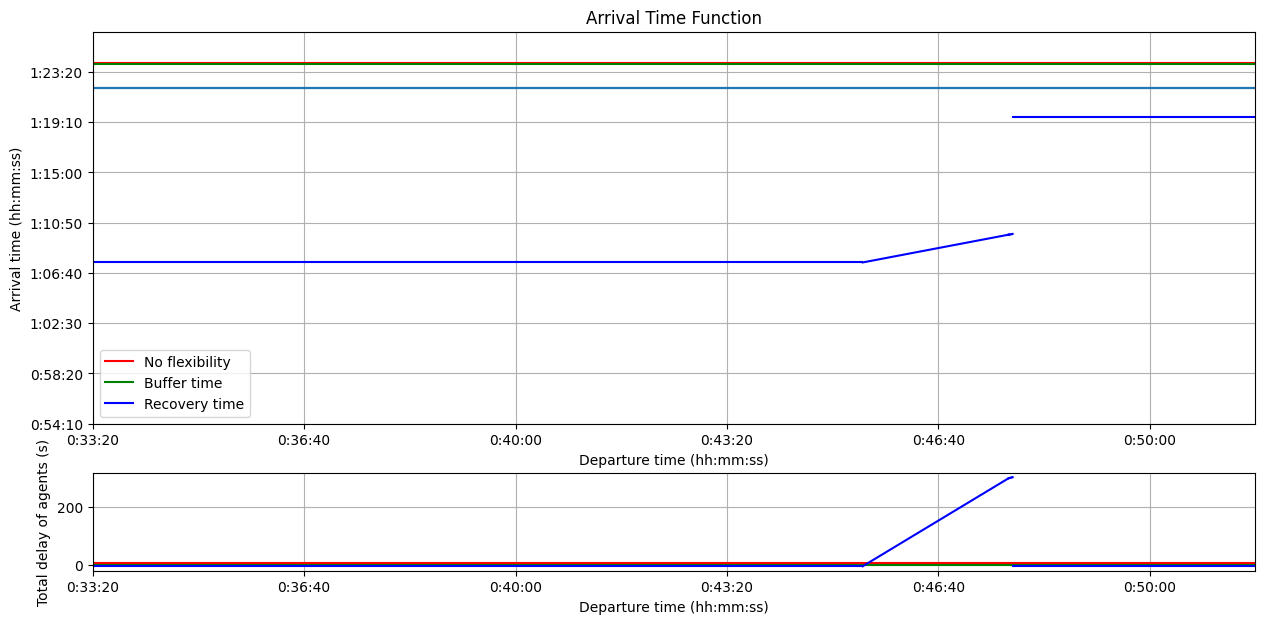

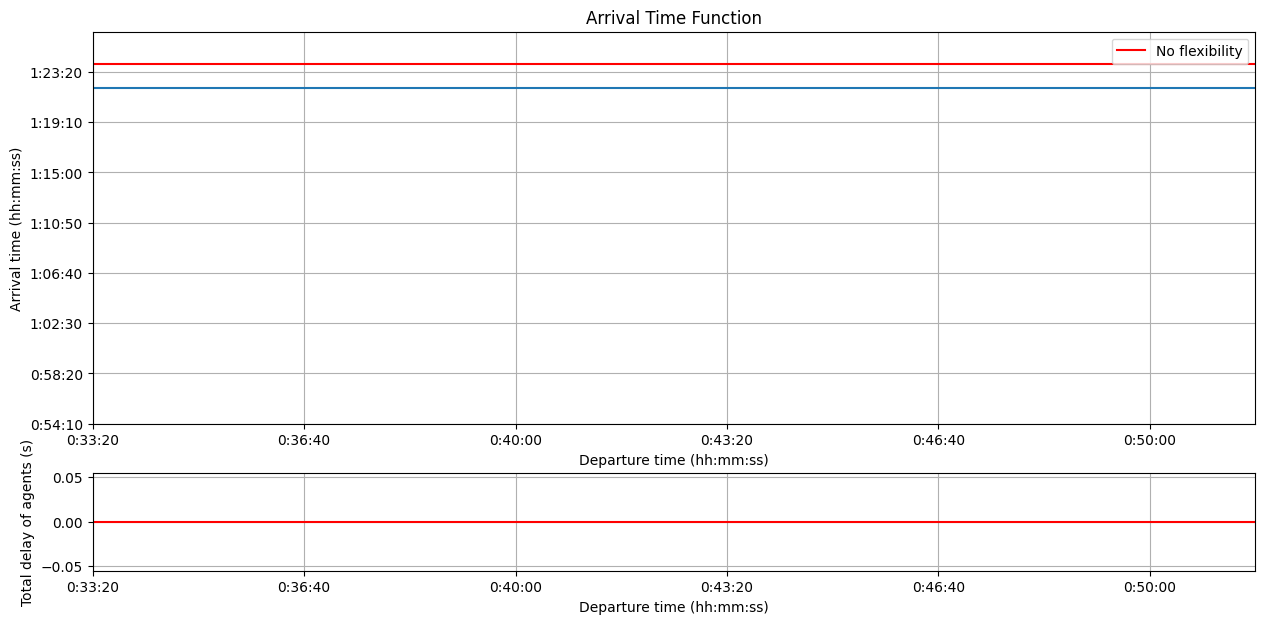

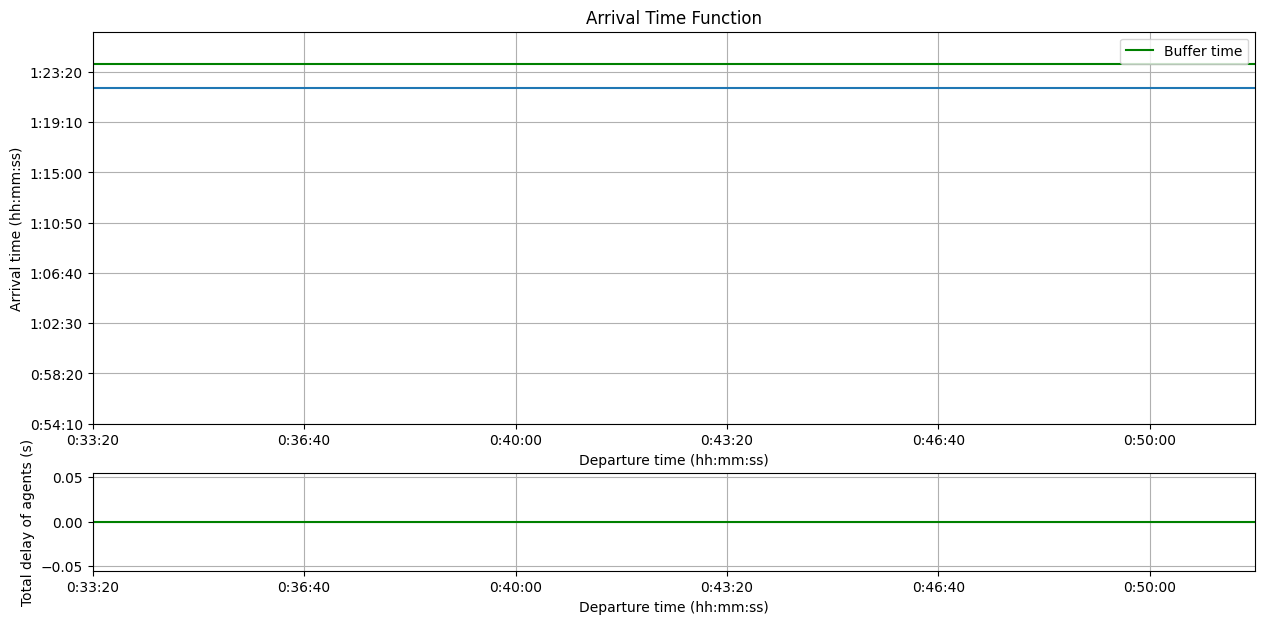

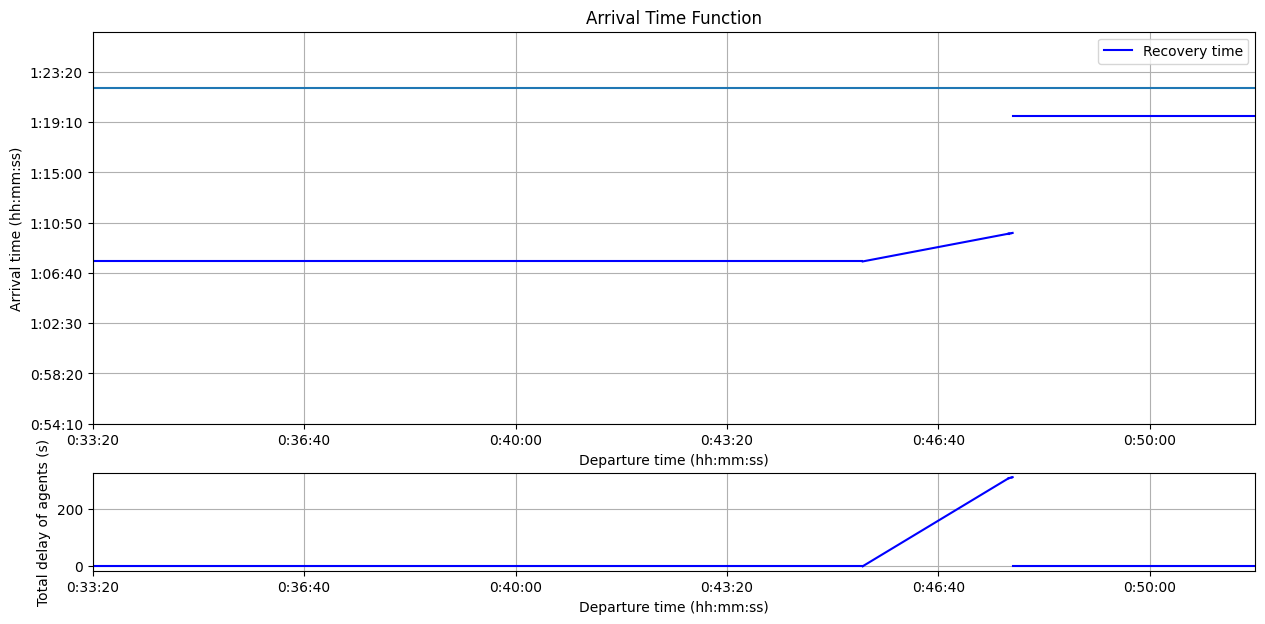

In [42]:
pybooklogger.setLevel(logging.WARNING)
experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 5}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': -5}

kwargs = {"min_x": 2000, "max_x": 3100, "min_y": 3250, "max_y": 5200, "expected_arrival_time": 4920}
plot_experiments(experiments, **kwargs)

experiments[0].metadata = {'color': 'Red', 'label': 'No flexibility', 'offset': 0}
experiments[1].metadata = {'color': 'Green', 'label': 'Buffer time', 'offset': 0}
experiments[2].metadata = {'color': 'Blue', 'label': 'Recovery time', 'offset': 0}

plot_experiments([experiments[0]], **kwargs)
plot_experiments([experiments[1]], **kwargs)
plot_experiments([experiments[2]], **kwargs)

### Time statistics

In [40]:
def sum_cols(df1, cols, name):
    df2 = df1.drop(columns=cols)
    df2[name] = df1[cols].sum(axis=1)
    return df2

time_df = pd.DataFrame([exp.get_running_time() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

setup_cols = ["track graph creation", "routing graph creation"]
recompute_cols = ["unsafe interval generation", "safe interval generation", "bt and crt generation", "converting routes to blocks"]
search_cols = ["FlexSIPP search time"]

time_df = sum_cols(time_df, setup_cols, "Setup Time")
time_df = sum_cols(time_df, recompute_cols, "Recompute Time")
time_df = sum_cols(time_df, search_cols, "Search Time")
time_df

,Setup Time,Recompute Time,Search Time
No flexibility,70.114086,182.907857,6.534
Buffer time,70.114086,182.857506,99.381
Recovery time,70.114086,182.872953,17.951


### Search Node Statistics


In [ ]:
nodes_df = pd.DataFrame([exp.get_complexity() for exp in experiments], index=[exp.metadata['label'] for exp in experiments])

nodes_df

### Output paths found


In [ ]:
for key, value in experiments[2].results[3].items():
    delayed_trains = {i: v for i,v in enumerate(value[0][4]) if float(v[0]) > 0}
    print(f"{key.replace('r-', '')}\nearliest departure: {int(min(float(value[0][1]), float(value[0][2])) / 60)}\ndepart before: {int(float(value[0][2]) / 60)}\narrive at: {int((float(value[0][1]) + float(value[0][3])) / 60)}\ndelays trains: {delayed_trains}")

### Path statistics


In [ ]:
for exp in experiments:
    print(f"Differend paths found for {exp.metadata['label']}: {sum(exp.results[2].values())}")